# 📊 Climate Data Integration & Analysis

**Purpose**: Combine all climate text datasets (RSS headlines, sentiment-labeled headlines, and tweets) with comprehensive analysis

## 🎯 Objectives
1. **Merge RSS headlines (449) + Sentiment headlines (1,025)** = ~1,474 total headlines
2. **Standardize column schemas** across datasets
3. **Create unified metadata framework**
4. **Statistical comparison** of data sources
5. **Text overlap analysis** between RSS and sentiment datasets

## 📁 Input Datasets
- `climate_headlines_combined_clean.csv` (449 RSS headlines)
- `climate_headlines_sentiment.csv` (1,025 sentiment-labeled headlines)
- `climate_tweets_cleaned.csv` (8,968 tweets)

---

## 📚 Setup & Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import re
from collections import Counter
from urllib.parse import urlparse
import json
from pathlib import Path

# Text similarity and processing
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("📦 All libraries imported successfully!")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📦 All libraries imported successfully!
📅 Analysis date: 2025-08-20 19:01:09


## 📂 Load All Datasets

In [3]:
# Define file paths
data_dir = Path("../data/processed")
raw_data_dir = Path("../../Datasets")

# Load RSS headlines (from previous processing)
rss_headlines_path = data_dir / "climate_headlines_combined_clean.csv"
df_rss = pd.read_csv(rss_headlines_path)
print(f"📰 RSS Headlines loaded: {len(df_rss):,} records")
print(f"   Columns: {list(df_rss.columns)}")

# Load sentiment-labeled headlines (new dataset)
sentiment_headlines_path = raw_data_dir / "Climate Change News" / "climate_headlines_sentiment.csv"
df_sentiment = pd.read_csv(sentiment_headlines_path)
print(f"\n🎭 Sentiment Headlines loaded: {len(df_sentiment):,} records")
print(f"   Columns: {list(df_sentiment.columns)}")

# Load cleaned tweets
tweets_path = data_dir / "climate_tweets_cleaned.csv"
df_tweets = pd.read_csv(tweets_path)
print(f"\n🐦 Tweets loaded: {len(df_tweets):,} records")
print(f"   Columns: {list(df_tweets.columns)}")

print(f"\n📊 Total text samples: {len(df_rss) + len(df_sentiment) + len(df_tweets):,}")

📰 RSS Headlines loaded: 448 records
   Columns: ['title', 'summary', 'source', 'url', 'published_date', 'collected_date', 'text_length', 'summary_length', 'title_words', 'title_chars', 'source_file', 'file_timestamp', 'has_summary', 'has_published_date', 'title_quality']

🎭 Sentiment Headlines loaded: 1,024 records
   Columns: ['Unnamed: 0', 'Headline', 'Link', 'Content', 'Sentiment', 'Justification']

🐦 Tweets loaded: 8,968 records
   Columns: ['text', 'Timestamp', 'date', 'hour', 'UserName', 'UserScreenName', 'Comments', 'Likes', 'Retweets', 'total_engagement', 'clean_word_count', 'clean_text_length', 'is_original', 'is_retweet', 'is_quote', 'has_climate_keywords', 'quality_score', 'high_quality', 'Tweet URL']

📊 Total text samples: 10,440


## 🔍 Explore New Sentiment Dataset

In [4]:
# Examine sentiment dataset structure
print("🎭 SENTIMENT DATASET ANALYSIS")
print("=" * 50)

print(f"Shape: {df_sentiment.shape}")
print(f"\nColumn details:")
for col in df_sentiment.columns:
    print(f"  • {col}: {df_sentiment[col].dtype}")

print(f"\nSample rows:")
display(df_sentiment.head(3))

print(f"\nSentiment distribution:")
sentiment_counts = df_sentiment['Sentiment'].value_counts().sort_index()
print(sentiment_counts)

print(f"\nSentiment statistics:")
print(df_sentiment['Sentiment'].describe())

🎭 SENTIMENT DATASET ANALYSIS
Shape: (1024, 6)

Column details:
  • Unnamed: 0: int64
  • Headline: object
  • Link: object
  • Content: object
  • Sentiment: float64
  • Justification: object

Sample rows:


,Unnamed: 0,Headline,Link,Content,Sentiment,Justification
0,0,Australia's year ahead in climate and environm...,https://www.abc.net.au/news/science/2024-01-23...,The year has barely started and extreme weath...,0.0,The headline is unclear about its direct impac...
1,1,Projections reveal the vulnerability of freshw...,https://news.griffith.edu.au/2024/01/09/projec...,"“Water from groundwater, rivers and rainfall ...",-0.5,The vulnerability of freshwater is concerning ...
2,2,"Record heat in 2023 worsened global droughts, ...",https://www.anu.edu.au/news/all-news/record-he...,2023 saw an increase in the frequency and int...,-1.0,The headline describes worsening environmental...



Sentiment distribution:
Sentiment
-1.0    275
-0.5    152
 0.0    213
 0.5    231
 1.0    152
Name: count, dtype: int64

Sentiment statistics:
count    1023.000000
mean       -0.081623
std         0.710513
min        -1.000000
25%        -1.000000
50%         0.000000
75%         0.500000
max         1.000000
Name: Sentiment, dtype: float64


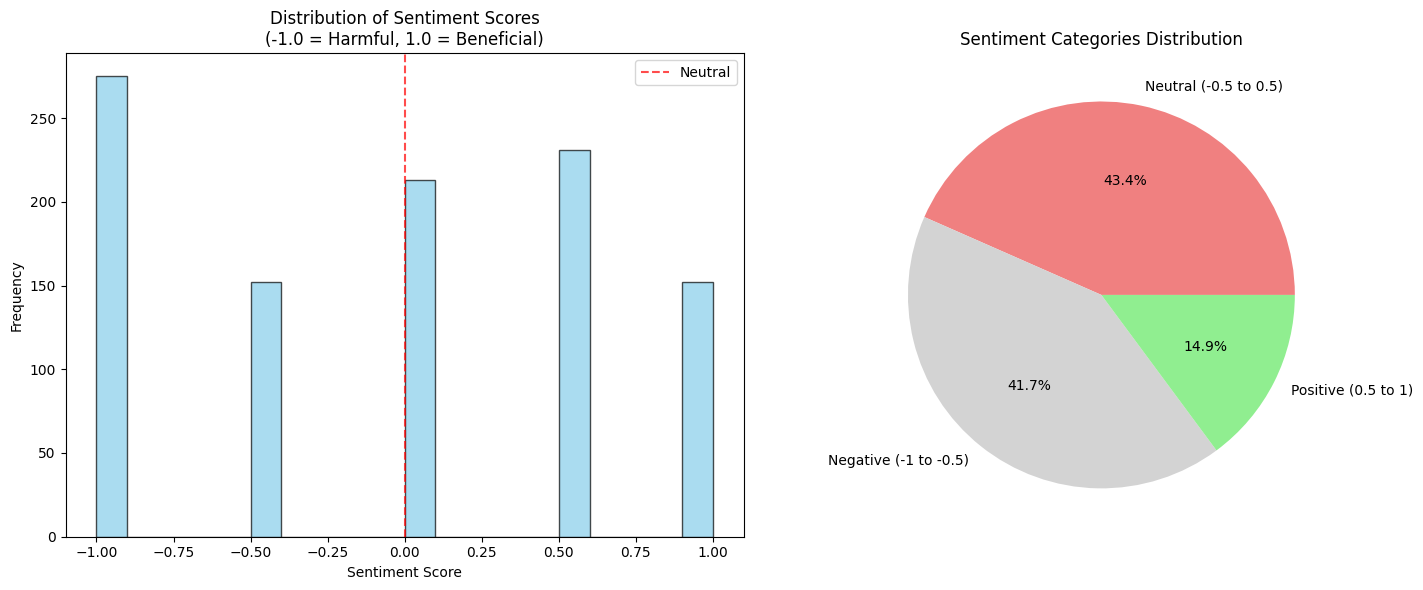

📊 Sentiment Category Breakdown:
  • Neutral (-0.5 to 0.5): 444 (43.4%)
  • Negative (-1 to -0.5): 427 (41.7%)
  • Positive (0.5 to 1): 152 (14.8%)


In [5]:
# Visualize sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sentiment histogram
ax1.hist(df_sentiment['Sentiment'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Sentiment Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sentiment Scores\n(-1.0 = Harmful, 1.0 = Beneficial)')
ax1.axvline(0, color='red', linestyle='--', alpha=0.7, label='Neutral')
ax1.legend()

# Sentiment categories
sentiment_categories = pd.cut(df_sentiment['Sentiment'], 
                            bins=[-1.1, -0.5, 0.5, 1.1], 
                            labels=['Negative (-1 to -0.5)', 'Neutral (-0.5 to 0.5)', 'Positive (0.5 to 1)'])
sentiment_cat_counts = sentiment_categories.value_counts()

ax2.pie(sentiment_cat_counts.values, labels=sentiment_cat_counts.index, autopct='%1.1f%%', 
        colors=['lightcoral', 'lightgray', 'lightgreen'])
ax2.set_title('Sentiment Categories Distribution')

plt.tight_layout()
plt.show()

print(f"📊 Sentiment Category Breakdown:")
for cat, count in sentiment_cat_counts.items():
    pct = (count / len(df_sentiment)) * 100
    print(f"  • {cat}: {count:,} ({pct:.1f}%)")

## 🔄 Standardize Column Schemas

In [6]:
# Standardize RSS headlines dataset
df_rss_std = df_rss.copy()
df_rss_std['dataset_source'] = 'RSS_Headlines'
df_rss_std['text'] = df_rss_std['title']
df_rss_std['content'] = df_rss_std['summary']
df_rss_std['url'] = df_rss_std['url']
df_rss_std['timestamp'] = pd.to_datetime(df_rss_std['published_date'])
df_rss_std['text_length'] = df_rss_std['title'].str.len()
df_rss_std['source_category'] = df_rss_std['source']

print(f"📰 RSS Headlines standardized: {len(df_rss_std):,} records")

# Standardize sentiment headlines dataset
df_sentiment_std = df_sentiment.copy()
df_sentiment_std['dataset_source'] = 'Sentiment_Headlines'
df_sentiment_std['text'] = df_sentiment_std['Headline']
df_sentiment_std['content'] = df_sentiment_std['Content']
df_sentiment_std['url'] = df_sentiment_std['Link']
df_sentiment_std['sentiment_score'] = df_sentiment_std['Sentiment']
df_sentiment_std['sentiment_justification'] = df_sentiment_std['Justification']
df_sentiment_std['text_length'] = df_sentiment_std['Headline'].str.len()

# Extract source from URL for sentiment dataset
def extract_source_from_url(url):
    try:
        domain = urlparse(url).netloc
        # Remove www. and extract main domain
        domain = re.sub(r'^www\.', '', domain)
        return domain
    except:
        return 'Unknown'

df_sentiment_std['source_category'] = df_sentiment_std['url'].apply(extract_source_from_url)
df_sentiment_std['timestamp'] = None  # No timestamp in sentiment dataset

print(f"🎭 Sentiment Headlines standardized: {len(df_sentiment_std):,} records")

# Standardize tweets dataset
df_tweets_std = df_tweets.copy()
df_tweets_std['dataset_source'] = 'Social_Media_Tweets'
df_tweets_std['content'] = df_tweets_std['text']  # Full content is the tweet text
df_tweets_std['url'] = df_tweets_std['Tweet URL']
df_tweets_std['timestamp'] = pd.to_datetime(df_tweets_std['Timestamp'])
df_tweets_std['text_length'] = df_tweets_std['text'].str.len()
df_tweets_std['source_category'] = 'Twitter'

print(f"🐦 Tweets standardized: {len(df_tweets_std):,} records")

📰 RSS Headlines standardized: 448 records
🎭 Sentiment Headlines standardized: 1,024 records
🐦 Tweets standardized: 8,968 records


## 🔗 Create Unified Headlines Dataset

In [7]:
# Define common columns for headlines datasets
common_headline_cols = [
    'text', 'content', 'url', 'timestamp', 'text_length', 
    'source_category', 'dataset_source'
]

# Prepare RSS headlines for combination
df_rss_combined = df_rss_std[common_headline_cols].copy()
df_rss_combined['has_sentiment_label'] = False
df_rss_combined['sentiment_score'] = None
df_rss_combined['sentiment_justification'] = None

# Prepare sentiment headlines for combination
df_sentiment_combined = df_sentiment_std[common_headline_cols + ['sentiment_score', 'sentiment_justification']].copy()
df_sentiment_combined['has_sentiment_label'] = True

# Combine both headline datasets
df_headlines_unified = pd.concat([
    df_rss_combined,
    df_sentiment_combined
], ignore_index=True)

print(f"🔗 UNIFIED HEADLINES DATASET")
print(f"   Total headlines: {len(df_headlines_unified):,}")
print(f"   RSS headlines: {len(df_rss_combined):,}")
print(f"   Sentiment headlines: {len(df_sentiment_combined):,}")
print(f"   With sentiment labels: {df_headlines_unified['has_sentiment_label'].sum():,}")

# Display sample
print(f"\nSample unified headlines:")
display(df_headlines_unified.head(3))

🔗 UNIFIED HEADLINES DATASET
   Total headlines: 1,472
   RSS headlines: 448
   Sentiment headlines: 1,024
   With sentiment labels: 1,024

Sample unified headlines:


,text,content,url,timestamp,text_length,source_category,dataset_source,has_sentiment_label,sentiment_score,sentiment_justification
0,Duration of heat waves accelerating faster tha...,Duration of heat waves accelerating faster tha...,https://news.google.com/rss/articles/CBMingFBV...,2025-07-08 07:00:00,78,Google_News_Global_Warming,RSS_Headlines,False,NaN,None
1,"Why Your Next Flight, Not Recycling, Will Have...","Why Your Next Flight, Not Recycling, Will Have...",https://news.google.com/rss/articles/CBMiswFBV...,2025-08-18 20:25:00,87,Google_News_Global_Warming,RSS_Headlines,False,NaN,None
2,"Global Warmings Six Americas, Fall 2024 - Yale...","Global Warmings Six Americas, Fall 2024 Yale P...",https://news.google.com/rss/articles/CBMilAFBV...,2025-03-20 07:00:00,86,Google_News_Global_Warming,RSS_Headlines,False,NaN,None


## 📊 Text Overlap Analysis

In [8]:
# Analyze text overlap between RSS and sentiment datasets
print("🔍 TEXT OVERLAP ANALYSIS")
print("=" * 50)

# Get texts from each dataset
rss_texts = set(df_rss_std['text'].str.lower().str.strip())
sentiment_texts = set(df_sentiment_std['text'].str.lower().str.strip())

# Find exact matches
exact_matches = rss_texts.intersection(sentiment_texts)
print(f"📝 Exact text matches: {len(exact_matches)}")

if len(exact_matches) > 0:
    print(f"\nSample exact matches:")
    for i, match in enumerate(list(exact_matches)[:3]):
        print(f"  {i+1}. {match[:100]}...")

# Analyze URL overlap
rss_urls = set(df_rss_std['url'].dropna())
sentiment_urls = set(df_sentiment_std['url'].dropna())
url_matches = rss_urls.intersection(sentiment_urls)
print(f"\n🔗 URL matches: {len(url_matches)}")

# Analyze source overlap
rss_sources = set(df_rss_std['source_category'].dropna())
sentiment_sources = set(df_sentiment_std['source_category'].dropna())
source_matches = rss_sources.intersection(sentiment_sources)
print(f"\n📰 Source overlaps: {len(source_matches)}")
print(f"   Common sources: {sorted(list(source_matches))}")

# Calculate text similarity for a sample
def calculate_similarity(text1, text2):
    return SequenceMatcher(None, text1.lower(), text2.lower()).ratio()

print(f"\n🔍 Similarity Analysis (sample of 100 texts from each dataset):")
sample_rss = df_rss_std['text'].dropna().sample(min(100, len(df_rss_std))).tolist()
sample_sentiment = df_sentiment_std['text'].dropna().sample(min(100, len(df_sentiment_std))).tolist()

high_similarity_pairs = []
similarity_threshold = 0.8

for i, rss_text in enumerate(sample_rss[:20]):  # Limit for performance
    for j, sent_text in enumerate(sample_sentiment[:20]):
        similarity = calculate_similarity(rss_text, sent_text)
        if similarity > similarity_threshold:
            high_similarity_pairs.append((rss_text, sent_text, similarity))

print(f"   High similarity pairs (>{similarity_threshold}): {len(high_similarity_pairs)}")
if high_similarity_pairs:
    for i, (text1, text2, sim) in enumerate(high_similarity_pairs[:3]):
        print(f"   Pair {i+1} (similarity: {sim:.3f}):")
        print(f"     RSS: {text1[:80]}...")
        print(f"     Sentiment: {text2[:80]}...")

🔍 TEXT OVERLAP ANALYSIS
📝 Exact text matches: 0

🔗 URL matches: 0

📰 Source overlaps: 0
   Common sources: []

🔍 Similarity Analysis (sample of 100 texts from each dataset):
   High similarity pairs (>0.8): 0


## 📈 Statistical Comparison Across Datasets

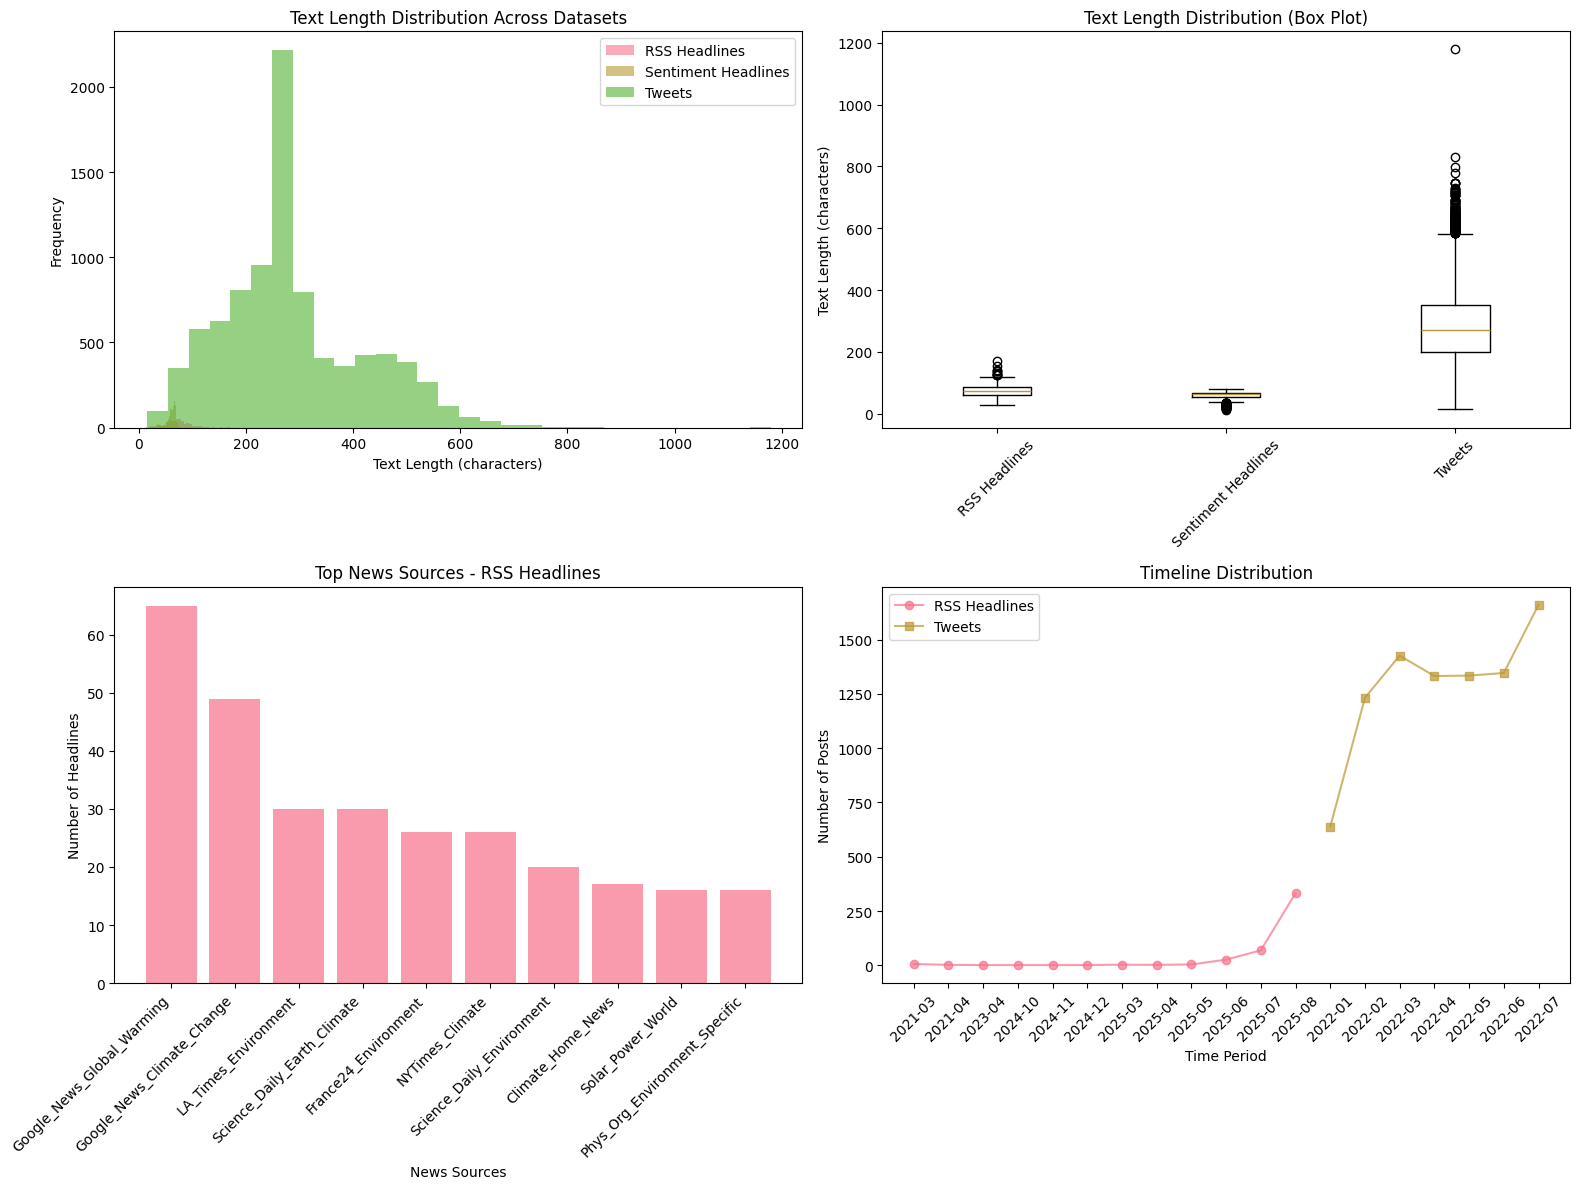

📊 STATISTICAL SUMMARY

RSS Headlines:
   Count: 448
   Avg text length: 74.7 chars
   Text length range: 27 - 170 chars
   Date range: 2021-03-05 to 2025-08-20
   Unique sources: 39

Sentiment Headlines:
   Count: 1,024
   Avg text length: 58.9 chars
   Text length range: 13 - 79 chars
   Unique sources: 312

Tweets:
   Count: 8,968
   Avg text length: 285.9 chars
   Text length range: 16 - 1179 chars
   Date range: 2022-01-17 to 2022-07-18
   Unique sources: 1


In [9]:
# Compare text length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Text length comparison
ax1 = axes[0, 0]
datasets = {
    'RSS Headlines': df_rss_std['text_length'],
    'Sentiment Headlines': df_sentiment_std['text_length'],
    'Tweets': df_tweets_std['text_length']
}

for label, lengths in datasets.items():
    ax1.hist(lengths, alpha=0.6, label=label, bins=30)

ax1.set_xlabel('Text Length (characters)')
ax1.set_ylabel('Frequency')
ax1.set_title('Text Length Distribution Across Datasets')
ax1.legend()

# Box plot for text lengths
ax2 = axes[0, 1]
length_data = []
length_labels = []
for label, lengths in datasets.items():
    length_data.append(lengths.dropna())
    length_labels.append(label)

ax2.boxplot(length_data, labels=length_labels)
ax2.set_ylabel('Text Length (characters)')
ax2.set_title('Text Length Distribution (Box Plot)')
ax2.tick_params(axis='x', rotation=45)

# Source distribution for headlines
ax3 = axes[1, 0]
rss_source_counts = df_rss_std['source_category'].value_counts().head(10)
sentiment_source_counts = df_sentiment_std['source_category'].value_counts().head(10)

x_pos = np.arange(len(rss_source_counts))
ax3.bar(x_pos, rss_source_counts.values, alpha=0.7, label='RSS Headlines')
ax3.set_xlabel('News Sources')
ax3.set_ylabel('Number of Headlines')
ax3.set_title('Top News Sources - RSS Headlines')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(rss_source_counts.index, rotation=45, ha='right')

# Timeline comparison
ax4 = axes[1, 1]
# RSS headlines timeline
rss_dates = pd.to_datetime(df_rss_std['timestamp']).dropna()
if len(rss_dates) > 0:
    rss_monthly = rss_dates.dt.to_period('M').value_counts().sort_index()
    ax4.plot(rss_monthly.index.astype(str), rss_monthly.values, 
             marker='o', label='RSS Headlines', alpha=0.7)

# Tweets timeline
tweet_dates = pd.to_datetime(df_tweets_std['timestamp']).dropna()
if len(tweet_dates) > 0:
    tweet_monthly = tweet_dates.dt.to_period('M').value_counts().sort_index()
    ax4.plot(tweet_monthly.index.astype(str), tweet_monthly.values, 
             marker='s', label='Tweets', alpha=0.7)

ax4.set_xlabel('Time Period')
ax4.set_ylabel('Number of Posts')
ax4.set_title('Timeline Distribution')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print statistical summary
print(f"📊 STATISTICAL SUMMARY")
print(f"=" * 50)
for name, df in [('RSS Headlines', df_rss_std), ('Sentiment Headlines', df_sentiment_std), ('Tweets', df_tweets_std)]:
    print(f"\n{name}:")
    print(f"   Count: {len(df):,}")
    print(f"   Avg text length: {df['text_length'].mean():.1f} chars")
    print(f"   Text length range: {df['text_length'].min()} - {df['text_length'].max()} chars")
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        dates = pd.to_datetime(df['timestamp']).dropna()
        print(f"   Date range: {dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}")
    print(f"   Unique sources: {df['source_category'].nunique()}")

## 🏗️ Create Master Metadata Framework

In [10]:
# Create comprehensive metadata for the integrated dataset
timestamp_str = datetime.now().strftime('%Y%m%d_%H%M%S')

metadata = {
    'integration_info': {
        'created_date': datetime.now().isoformat(),
        'integration_version': '1.0',
        'total_datasets': 3,
        'total_samples': int(len(df_headlines_unified) + len(df_tweets_std))
    },
    'dataset_breakdown': {
        'headlines_total': int(len(df_headlines_unified)),
        'headlines_rss': int(len(df_rss_std)),
        'headlines_sentiment': int(len(df_sentiment_std)),
        'tweets': int(len(df_tweets_std))
    },
    'data_quality': {
        'exact_text_overlaps': len(exact_matches),
        'url_overlaps': len(url_matches),
        'source_overlaps': len(source_matches),
        'high_similarity_pairs': len(high_similarity_pairs)
    },
    'text_statistics': {
        'rss_avg_length': float(df_rss_std['text_length'].mean()),
        'sentiment_avg_length': float(df_sentiment_std['text_length'].mean()),
        'tweets_avg_length': float(df_tweets_std['text_length'].mean())
    },
    'temporal_coverage': {
        'rss_date_range': {
            'start': df_rss_std['timestamp'].min().isoformat() if df_rss_std['timestamp'].notna().any() else None,
            'end': df_rss_std['timestamp'].max().isoformat() if df_rss_std['timestamp'].notna().any() else None
        },
        'tweets_date_range': {
            'start': df_tweets_std['timestamp'].min().isoformat() if df_tweets_std['timestamp'].notna().any() else None,
            'end': df_tweets_std['timestamp'].max().isoformat() if df_tweets_std['timestamp'].notna().any() else None
        }
    },
    'source_diversity': {
        'rss_unique_sources': int(df_rss_std['source_category'].nunique()),
        'sentiment_unique_sources': int(df_sentiment_std['source_category'].nunique()),
        'common_sources': sorted(list(source_matches))
    },
    'sentiment_analysis': {
        'labeled_headlines': int(df_sentiment_std.shape[0]),
        'sentiment_distribution': {
            'negative': int((df_sentiment_std['sentiment_score'] < -0.5).sum()),
            'neutral': int((df_sentiment_std['sentiment_score'].between(-0.5, 0.5)).sum()),
            'positive': int((df_sentiment_std['sentiment_score'] > 0.5).sum())
        },
        'avg_sentiment': float(df_sentiment_std['sentiment_score'].mean()),
        'sentiment_std': float(df_sentiment_std['sentiment_score'].std())
    }
}

print("🏗️ MASTER METADATA FRAMEWORK")
print("=" * 50)
print(json.dumps(metadata, indent=2, default=str))

🏗️ MASTER METADATA FRAMEWORK
{
  "integration_info": {
    "created_date": "2025-08-20T19:02:20.308503",
    "integration_version": "1.0",
    "total_datasets": 3,
    "total_samples": 10440
  },
  "dataset_breakdown": {
    "headlines_total": 1472,
    "headlines_rss": 448,
    "headlines_sentiment": 1024,
    "tweets": 8968
  },
  "data_quality": {
    "exact_text_overlaps": 0,
    "url_overlaps": 0,
    "source_overlaps": 0,
    "high_similarity_pairs": 0
  },
  "text_statistics": {
    "rss_avg_length": 74.68303571428571,
    "sentiment_avg_length": 58.9287109375,
    "tweets_avg_length": 285.86161909009815
  },
  "temporal_coverage": {
    "rss_date_range": {
      "start": "2021-03-05T12:47:55",
      "end": "2025-08-20T16:02:58"
    },
    "tweets_date_range": {
      "start": "2022-01-17T20:46:46+00:00",
      "end": "2022-07-18T23:57:23+00:00"
    }
  },
  "source_diversity": {
    "rss_unique_sources": 39,
    "sentiment_unique_sources": 312,
    "common_sources": []
  },
  "

## 💾 Save Integrated Datasets

In [11]:
# Ensure output directory exists
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Save unified headlines dataset
headlines_output_path = output_dir / f"climate_headlines_unified_{timestamp_str}.csv"
df_headlines_unified.to_csv(headlines_output_path, index=False)
print(f"💾 Unified headlines saved: {headlines_output_path}")
print(f"   Records: {len(df_headlines_unified):,}")
print(f"   Size: {headlines_output_path.stat().st_size / 1024 / 1024:.2f} MB")

# Save individual standardized datasets
rss_std_path = output_dir / f"climate_headlines_rss_standardized_{timestamp_str}.csv"
df_rss_std.to_csv(rss_std_path, index=False)

sentiment_std_path = output_dir / f"climate_headlines_sentiment_standardized_{timestamp_str}.csv"
df_sentiment_std.to_csv(sentiment_std_path, index=False)

tweets_std_path = output_dir / f"climate_tweets_standardized_{timestamp_str}.csv"
df_tweets_std.to_csv(tweets_std_path, index=False)

print(f"\n📁 Individual standardized datasets saved:")
print(f"   RSS Headlines: {rss_std_path}")
print(f"   Sentiment Headlines: {sentiment_std_path}")
print(f"   Tweets: {tweets_std_path}")

# Save metadata
metadata_path = output_dir / f"integration_metadata_{timestamp_str}.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"\n📊 Metadata saved: {metadata_path}")

# Create summary file with file paths for next notebooks
file_registry = {
    'integration_timestamp': timestamp_str,
    'files': {
        'unified_headlines': str(headlines_output_path),
        'rss_headlines_std': str(rss_std_path),
        'sentiment_headlines_std': str(sentiment_std_path),
        'tweets_std': str(tweets_std_path),
        'metadata': str(metadata_path)
    },
    'record_counts': {
        'unified_headlines': len(df_headlines_unified),
        'rss_headlines': len(df_rss_std),
        'sentiment_headlines': len(df_sentiment_std),
        'tweets': len(df_tweets_std)
    }
}

registry_path = output_dir / "file_registry_latest.json"
with open(registry_path, 'w') as f:
    json.dump(file_registry, f, indent=2)
print(f"\n📋 File registry saved: {registry_path}")

💾 Unified headlines saved: ..\data\processed\climate_headlines_unified_20250820_190220.csv
   Records: 1,472
   Size: 0.75 MB

📁 Individual standardized datasets saved:
   RSS Headlines: ..\data\processed\climate_headlines_rss_standardized_20250820_190220.csv
   Sentiment Headlines: ..\data\processed\climate_headlines_sentiment_standardized_20250820_190220.csv
   Tweets: ..\data\processed\climate_tweets_standardized_20250820_190220.csv

📊 Metadata saved: ..\data\processed\integration_metadata_20250820_190220.json

📋 File registry saved: ..\data\processed\file_registry_latest.json


## 📊 Final Integration Summary

In [12]:
# Create comprehensive summary visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Dataset Composition',
        'Text Length Comparison',
        'Sentiment Distribution',
        'Data Quality Metrics'
    ),
    specs=[[{'type': 'pie'}, {'type': 'box'}],
           [{'type': 'bar'}, {'type': 'bar'}]]
)

# Dataset composition pie chart
fig.add_trace(
    go.Pie(
        labels=['RSS Headlines', 'Sentiment Headlines', 'Tweets'],
        values=[len(df_rss_std), len(df_sentiment_std), len(df_tweets_std)],
        name="Dataset Composition"
    ),
    row=1, col=1
)

# Text length box plots
for i, (name, data) in enumerate([
    ('RSS', df_rss_std['text_length']),
    ('Sentiment', df_sentiment_std['text_length']),
    ('Tweets', df_tweets_std['text_length'])
]):
    fig.add_trace(
        go.Box(y=data, name=name, showlegend=False),
        row=1, col=2
    )

# Sentiment distribution
sentiment_cats = ['Negative', 'Neutral', 'Positive']
sentiment_counts = [
    (df_sentiment_std['sentiment_score'] < -0.5).sum(),
    (df_sentiment_std['sentiment_score'].between(-0.5, 0.5)).sum(),
    (df_sentiment_std['sentiment_score'] > 0.5).sum()
]

fig.add_trace(
    go.Bar(
        x=sentiment_cats,
        y=sentiment_counts,
        name="Sentiment Distribution",
        marker_color=['red', 'gray', 'green'],
        showlegend=False
    ),
    row=2, col=1
)

# Data quality metrics
quality_metrics = ['Exact Matches', 'URL Overlaps', 'Source Overlaps', 'High Similarity']
quality_values = [
    len(exact_matches),
    len(url_matches),
    len(source_matches),
    len(high_similarity_pairs)
]

fig.add_trace(
    go.Bar(
        x=quality_metrics,
        y=quality_values,
        name="Quality Metrics",
        marker_color='lightblue',
        showlegend=False
    ),
    row=2, col=2
)

fig.update_layout(
    height=800,
    title_text="Climate Data Integration - Comprehensive Summary",
    title_x=0.5
)

fig.show()

print(f"\n🎯 INTEGRATION COMPLETE!")
print(f"=" * 50)
print(f"📊 Total Climate Text Samples: {len(df_headlines_unified) + len(df_tweets_std):,}")
print(f"   • Headlines (Unified): {len(df_headlines_unified):,}")
print(f"     - RSS Headlines: {len(df_rss_std):,}")
print(f"     - Sentiment Headlines: {len(df_sentiment_std):,}")
print(f"   • Social Media Tweets: {len(df_tweets_std):,}")
print(f"\n🎭 Sentiment-Labeled Data: {len(df_sentiment_std):,} headlines")
print(f"🔗 Data Overlaps Identified: {len(exact_matches)} exact matches")
print(f"📁 Files Ready for Next Phase: Emotion Classification Training")
print(f"\n✨ Ready for Step 2: GoEmotions Emotion Classifier Training!")


🎯 INTEGRATION COMPLETE!
📊 Total Climate Text Samples: 10,440
   • Headlines (Unified): 1,472
     - RSS Headlines: 448
     - Sentiment Headlines: 1,024
   • Social Media Tweets: 8,968

🎭 Sentiment-Labeled Data: 1,024 headlines
🔗 Data Overlaps Identified: 0 exact matches
📁 Files Ready for Next Phase: Emotion Classification Training

✨ Ready for Step 2: GoEmotions Emotion Classifier Training!
